## 2.3.1-2.3.2 ランキングにおける各種重要度重みの大きさを比較

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pandas import DataFrame
from tqdm import tqdm
from sklearn.utils import check_random_state
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.style.use('ggplot')

from dataset import generate_synthetic_data, calc_true_value
from estimators import calc_weights
from utils import eps_greedy_policy

In [2]:
## シミュレーション設定
num_runs = 1000 # シミュレーションの繰り返し回数
dim_context = 5 # 特徴量xの次元
num_data = 2000 # ログデータのサイズ
beta = 1 # データ収集方策のパラメータ
p = [0, 0, 1] # ユーザ行動の出現割合
random_state = 12345
num_actions_list = [2, 4, 6, 8, 10, 12] # ユニークなアイテム数, |A|
K_list = [2, 4, 6, 8, 10, 12] # ランキングの長さ


In [3]:
result_df_list = []
K = 8 # ランキングの長さ (デフォルト)
for num_actions in num_actions_list:
    random_ = check_random_state(random_state)
    theta = random_.normal(size=(dim_context, num_actions))
    M = random_.normal(size=(dim_context, num_actions))
    b = random_.normal(size=(1, num_actions))
    W = random_.uniform(0, 1, size=(K, K))

    for _ in tqdm(range(num_runs), desc=f"num_actions={num_actions}..."):
        ## データ収集方策が形成する分布に従いログデータを生成
        offline_logged_data = generate_synthetic_data(
            num_data=num_data, dim_context=dim_context, num_actions=num_actions,
            theta=theta, M=M, b=b, W=W, K=K, p=p, beta=beta, random_state=_
        )

        ## ログデータ上における評価方策の行動選択確率を計算
        pi = eps_greedy_policy(offline_logged_data["base_q_func"])

        ## シミュレーション結果を集計
        rank_weight_max, pos_weight_max, topk_weight_max = calc_weights(offline_logged_data, pi)
        result_df = DataFrame(
            [num_actions, rank_weight_max, pos_weight_max, topk_weight_max],
            index=["num_actions", "max_rank_weight", "max_pos_weight", "max_topk_weight"]
        )
        result_df_list.append(result_df.T)
result_df_actions = pd.concat(result_df_list).reset_index(level=0).groupby(["num_actions"]).mean()


num_actions=2...:   0%|          | 0/1000 [00:00<?, ?it/s]

num_actions=12...: 100%|██████████| 1000/1000 [01:02<00:00, 15.92it/s]


In [4]:
result_df_list = []
num_actions = 5 # ユニークなアイテム数 (デフォルト)
for K in K_list:
    random_ = check_random_state(random_state)
    theta = random_.normal(size=(dim_context, num_actions))
    M = random_.normal(size=(dim_context, num_actions))
    b = random_.normal(size=(1, num_actions))
    W = random_.uniform(0, 1, size=(K, K))

    for _ in tqdm(range(num_runs), desc=f"K={K}..."):
        ## データ収集方策が形成する分布に従いログデータを生成
        offline_logged_data = generate_synthetic_data(
            num_data=num_data, dim_context=dim_context, num_actions=num_actions,
            theta=theta, M=M, b=b, W=W, K=K, p=p, beta=beta, random_state=_
        )

        ## ログデータ上における評価方策の行動選択確率を計算
        pi = eps_greedy_policy(offline_logged_data["base_q_func"])

        ## シミュレーション結果を集計
        rank_weight_max, pos_weight_max, topk_weight_max = calc_weights(offline_logged_data, pi)
        result_df = DataFrame(
            [K, rank_weight_max, pos_weight_max, topk_weight_max],
            index=["K", "max_rank_weight", "max_pos_weight", "max_topk_weight"]
        )
        result_df_list.append(result_df.T)
result_df_k = pd.concat(result_df_list).reset_index(level=0).groupby(["K"]).mean()


K=12...: 100%|██████████| 1000/1000 [01:03<00:00, 15.86it/s]


## 図2.11

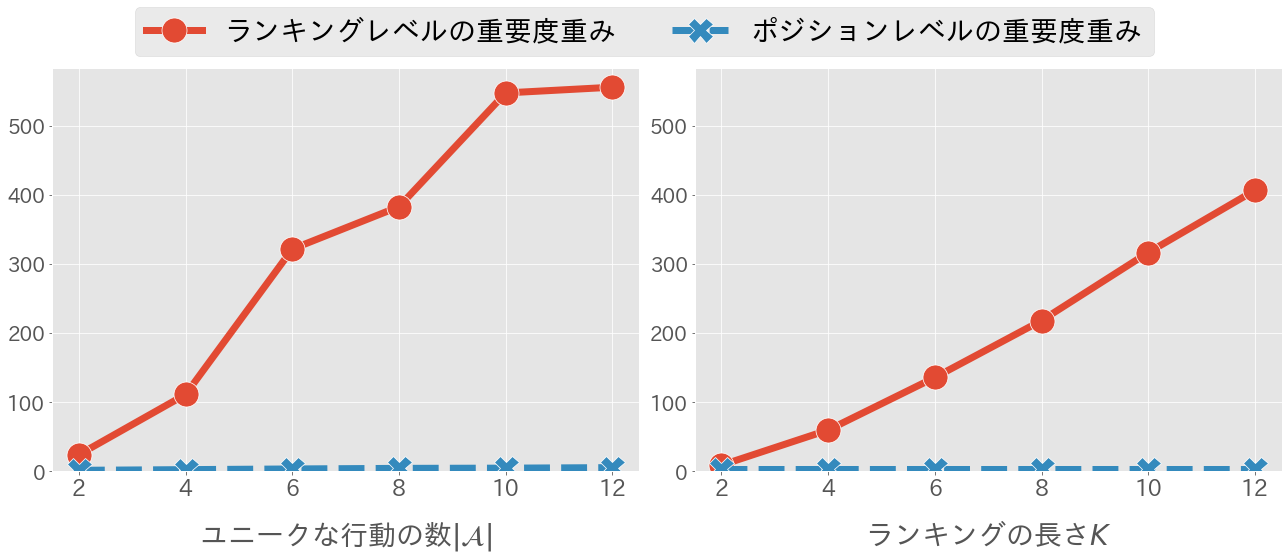

In [5]:
fig, ax_list = plt.subplots(1, 2, figsize=(18, 7), tight_layout=True)
for i, df in enumerate([result_df_actions, result_df_k]):
    ax = ax_list[i]
    x = "num_actions" if i == 0 else "K"
    for y in ["max_rank_weight", "max_pos_weight"]:
        if y == "max_pos_weight":
            marker = "X"
            line = "--"
        elif y == "max_topk_weight":
            marker = "*"
            line = "---"
        else:
            marker = "o"
            line = "-"
        sns.lineplot(
            markers=True,
            markersize=25,
            linewidth=7,
            legend=False,
            marker=marker,
            linestyle=line,
            x=x,
            y=y,
            ax=ax,
            data=df,
        )
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 585)
    ax.tick_params(axis="y", labelsize=20)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    if i == 0:
        ax.set_xlabel(r"ユニークな行動の数$|\mathcal{A}|$", fontsize=28)
        ax.set_xticks(num_actions_list)
        ax.set_xticklabels(num_actions_list, fontsize=22)
    else:
        ax.set_xlabel(r"ランキングの長さ$K$", fontsize=28)
        ax.set_xticks(K_list)
        ax.set_xticklabels(K_list, fontsize=22)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(
    ["ランキングレベルの重要度重み", "ポジションレベルの重要度重み"],
    fontsize=28, bbox_to_anchor=(0.5, 1.05), ncol=2, loc="center",
)


## 図2.18

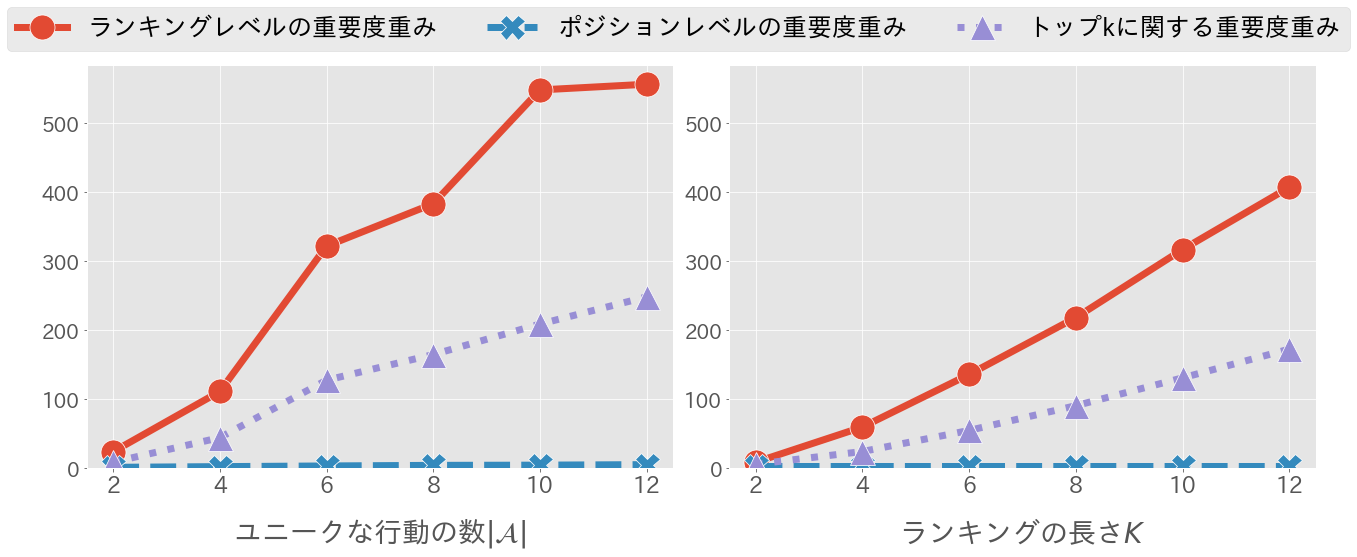

In [6]:
fig, ax_list = plt.subplots(1, 2, figsize=(18, 7), tight_layout=True)
for i, df in enumerate([result_df_actions, result_df_k]):
    ax = ax_list[i]
    x = "num_actions" if i == 0 else "K"
    for y in ["max_rank_weight", "max_pos_weight", "max_topk_weight"]:
        if y == "max_pos_weight":
            marker = "X"
            line = "--"
        elif y == "max_topk_weight":
            marker = "^"
            line = ":"
        else:
            marker = "o"
            line = "-"
        sns.lineplot(
            markers=True,
            markersize=25,
            linewidth=7,
            legend=False,
            marker=marker,
            linestyle=line,
            x=x,
            y=y,
            ax=ax,
            data=df,
        )
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 585)
    ax.tick_params(axis="y", labelsize=20)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    if i == 0:
        ax.set_xlabel(r"ユニークな行動の数$|\mathcal{A}|$", fontsize=28)
        ax.set_xticks(num_actions_list)
        ax.set_xticklabels(num_actions_list, fontsize=22)
    else:
        ax.set_xlabel(r"ランキングの長さ$K$", fontsize=28)
        ax.set_xticks(K_list)
        ax.set_xticklabels(K_list, fontsize=22)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(
    ["ランキングレベルの重要度重み", "ポジションレベルの重要度重み", "トップkに関する重要度重み"],
    fontsize=25, bbox_to_anchor=(0.5, 1.05), ncol=3, loc="center",
)
